In [1]:
import robot_plotter as rp
import models_functions as mf
import traj
import numpy as np
import matplotlib.pyplot as plt
import robot_sim as sim
import sim_helper_funcs as hfunc

## Script for running simulation of 6 robots localizing
For testing out the performance of an all-to-all information exchange, when many agents are involved.

In [2]:
# generate reference trajectory
dt = 0.01

pos1, y_IMU1_base, xa1 = hfunc.path1_slow(dt)
pos2, y_IMU2_base, xa2 = hfunc.path2_slow(dt)
pos3, y_IMU3_base, xa3 = hfunc.path3_slow(dt)
pos4, y_IMU4_base, xa4 = hfunc.path4_slow(dt)
pos5, y_IMU5_base, xa5 = hfunc.path5_slow(dt)
pos6, y_IMU6_base, xa6 = hfunc.path6_slow(dt)

pos_len = pos1.shape[1] # Assumes that all paths have the same length
#pos_len = 1000 # overwrite for debugging

# Generate anchors position:
xanc1, xanc2 = hfunc.anc_setup1()

In [3]:
R_b = 0.0009
R_r = 0.001
R_w = 0.0002
R_a = 0.004

anchor1 = sim.Anchor(x0=xanc1)
anchor2 = sim.Anchor(x0=xanc2)


In [4]:
list_seeds = [1061, 1, 19001, 7871871, 2289, 91667, 8, 6119077, 47, 5514]
#1061, 1, 19001, 7871871, 2289, 91667, 8, 6119077, 47, 5514
seeds_num = len(list_seeds)
# Initialize logs
x_logL1 = np.zeros((mf.STATE_LEN, pos_len, seeds_num))
P_logL1 = np.zeros((mf.STATE_LEN, mf.STATE_LEN, pos_len, seeds_num))
x_logL2 = np.zeros((mf.STATE_LEN, pos_len, seeds_num))
P_logL2 = np.zeros((mf.STATE_LEN, mf.STATE_LEN, pos_len, seeds_num))
x_logL3 = np.zeros((mf.STATE_LEN, pos_len, seeds_num))
P_logL3 = np.zeros((mf.STATE_LEN, mf.STATE_LEN, pos_len, seeds_num))
x_logL4 = np.zeros((mf.STATE_LEN, pos_len, seeds_num))
P_logL4 = np.zeros((mf.STATE_LEN, mf.STATE_LEN, pos_len, seeds_num))
x_logL5 = np.zeros((mf.STATE_LEN, pos_len, seeds_num))
P_logL5 = np.zeros((mf.STATE_LEN, mf.STATE_LEN, pos_len, seeds_num))
x_logL6 = np.zeros((mf.STATE_LEN, pos_len, seeds_num))
P_logL6 = np.zeros((mf.STATE_LEN, mf.STATE_LEN, pos_len, seeds_num))
nis_log1 = np.zeros((pos_len, seeds_num))
nis_log2 = np.zeros((pos_len, seeds_num))
nis_log3 = np.zeros((pos_len, seeds_num))
nis_log4 = np.zeros((pos_len, seeds_num))
nis_log5 = np.zeros((pos_len, seeds_num))
nis_log6 = np.zeros((pos_len, seeds_num))
abs_e_log1 = np.zeros((6, pos_len, seeds_num))
abs_e_log2 = np.zeros((6, pos_len, seeds_num))
abs_e_log3 = np.zeros((6, pos_len, seeds_num))
abs_e_log4 = np.zeros((6, pos_len, seeds_num))
abs_e_log5 = np.zeros((6, pos_len, seeds_num))
abs_e_log6 = np.zeros((6, pos_len, seeds_num))

# Sim settings
sr = R_r
sb = R_b
r_w = R_w
r_a = R_a
sim_max_dist = 50
thres = 12 # 99.5 % confidence
thres_IMU = 14.5 # 99.5 % confidence
out_freq = np.array([[0.0],[0.0],[0.0]]) # an outlier every second on average
bias_base = np.array([[0.07],[0.2],[0.2]]) # max magnitude of bias
amb = False

thres = 0
thres_IMU = 0
sim_max_dist = -1
#sr=0
#sb=0
#r_w = 0
#r_a = 0
#bias_base = np.array([[0.0],[0.0],[0.0]])

for j in range(seeds_num):
    print("seed: " + str(list_seeds[j]))
    # random bias:
    bias_vec = 2*bias_base*(np.random.rand(3, 1) - 0.5)

    np.random.seed(list_seeds[j])
    y_IMU1 = traj.gen_noise(y_IMU1_base.copy(), dt=dt, sigma=np.diag([r_w, r_a, r_a]), bias=bias_vec, out_freq=out_freq)
    y_IMU2 = traj.gen_noise(y_IMU2_base.copy(), dt=dt, sigma=np.diag([r_w, r_a, r_a]), bias=bias_vec, out_freq=out_freq)
    y_IMU3 = traj.gen_noise(y_IMU3_base.copy(), dt=dt, sigma=np.diag([r_w, r_a, r_a]), bias=bias_vec, out_freq=out_freq)
    y_IMU4 = traj.gen_noise(y_IMU4_base.copy(), dt=dt, sigma=np.diag([r_w, r_a, r_a]), bias=bias_vec, out_freq=out_freq)
    y_IMU5 = traj.gen_noise(y_IMU5_base.copy(), dt=dt, sigma=np.diag([r_w, r_a, r_a]), bias=bias_vec, out_freq=out_freq)
    y_IMU6 = traj.gen_noise(y_IMU6_base.copy(), dt=dt, sigma=np.diag([r_w, r_a, r_a]), bias=bias_vec, out_freq=out_freq)

    # Run LUFT algorithm
    robotL1 = sim.robot_luft(x0=xa1, path=pos1, imu=y_IMU1, dt=dt, id=111)
    robotL2 = sim.robot_luft(x0=xa2, path=pos2, imu=y_IMU2, dt=dt, id=222)
    robotL3 = sim.robot_luft(x0=xa3, path=pos3, imu=y_IMU3, dt=dt, id=333)
    robotL4 = sim.robot_luft(x0=xa4, path=pos4, imu=y_IMU4, dt=dt, id=444)
    robotL5 = sim.robot_luft(x0=xa5, path=pos5, imu=y_IMU5, dt=dt, id=555)
    robotL6 = sim.robot_luft(x0=xa6, path=pos6, imu=y_IMU6, dt=dt, id=666)

    for i in range(pos_len-1):
        robotL1.predict(imu_correct=True, thres=thres_IMU)
        robotL2.predict(imu_correct=True, thres=thres_IMU)
        robotL3.predict(imu_correct=True, thres=thres_IMU)
        robotL4.predict(imu_correct=True, thres=thres_IMU)
        robotL5.predict(imu_correct=True, thres=thres_IMU)
        robotL6.predict(imu_correct=True, thres=thres_IMU)
        # Set up a measurement pattern similar to the used communication protocol
        # First module:
        if (i > 0 and i % 200 == 0):
            hfunc.updateAllLuft(robotL1, [anchor1, anchor2], [robotL2, robotL3, robotL4, robotL5, robotL6], sr=sr, sb=sb, max_dist=sim_max_dist, thres=thres, amb=amb)
        # Second module:
        if (i > 0 and (i+33) % 200 == 0):
            hfunc.updateAllLuft(robotL2, [anchor1, anchor2], [robotL1, robotL3, robotL4, robotL5, robotL6], sr=sr, sb=sb, max_dist=sim_max_dist, thres=thres, amb=amb)
        # Third module:
        if (i > 0 and (i+66) % 200 == 0):
            hfunc.updateAllLuft(robotL3, [anchor1, anchor2], [robotL1, robotL2, robotL4, robotL5, robotL6], sr=sr, sb=sb, max_dist=sim_max_dist, thres=thres, amb=amb)
        # Fourth module:
        if (i > 0 and (i+100) % 200 == 0):
            hfunc.updateAllLuft(robotL4, [anchor1, anchor2], [robotL1, robotL2, robotL3, robotL5, robotL6], sr=sr, sb=sb, max_dist=sim_max_dist, thres=thres, amb=amb)
        # Fifth module:
        if (i > 0 and (i+133) % 200 == 0):
            hfunc.updateAllLuft(robotL5, [anchor1, anchor2], [robotL1, robotL2, robotL3, robotL4, robotL6], sr=sr, sb=sb, max_dist=sim_max_dist, thres=thres, amb=amb)
        # Sixth module:
        if (i > 0 and (i+166) % 200 == 0):
            hfunc.updateAllLuft(robotL6, [anchor1, anchor2], [robotL1, robotL2, robotL3, robotL4, robotL5], sr=sr, sb=sb, max_dist=sim_max_dist, thres=thres, amb=amb)

    # Save estimates and covariances:
    # Slicing, incase we want to run a shorter simulation
    x_logL1[:,:,j] = robotL1.x_log[:,:pos_len]
    P_logL1[:,:,:,j] = robotL1.P_log[:,:,:pos_len]
    x_logL2[:,:,j] = robotL2.x_log[:,:pos_len]
    P_logL2[:,:,:,j] = robotL2.P_log[:,:,:pos_len]
    x_logL3[:,:,j] = robotL3.x_log[:,:pos_len]
    P_logL3[:,:,:,j] = robotL3.P_log[:,:,:pos_len]
    x_logL4[:,:,j] = robotL4.x_log[:,:pos_len]
    P_logL4[:,:,:,j] = robotL4.P_log[:,:,:pos_len]
    x_logL5[:,:,j] = robotL5.x_log[:,:pos_len]
    P_logL5[:,:,:,j] = robotL5.P_log[:,:,:pos_len]
    x_logL6[:,:,j] = robotL6.x_log[:,:pos_len]
    P_logL6[:,:,:,j] = robotL6.P_log[:,:,:pos_len]
    nis_log1[:,j] = robotL1.nis_IMU[:pos_len]
    nis_log2[:,j] = robotL2.nis_IMU[:pos_len]
    nis_log3[:,j] = robotL3.nis_IMU[:pos_len]
    nis_log4[:,j] = robotL4.nis_IMU[:pos_len]
    nis_log5[:,j] = robotL5.nis_IMU[:pos_len]
    nis_log6[:,j] = robotL6.nis_IMU[:pos_len]
    abs_e_log1[:,:,j] = sim.error_bp(robotL1, bias_vec)[:,:pos_len]
    abs_e_log2[:,:,j] = sim.error_bp(robotL2, bias_vec)[:,:pos_len]
    abs_e_log3[:,:,j] = sim.error_bp(robotL3, bias_vec)[:,:pos_len]
    abs_e_log4[:,:,j] = sim.error_bp(robotL4, bias_vec)[:,:pos_len]
    abs_e_log5[:,:,j] = sim.error_bp(robotL5, bias_vec)[:,:pos_len]
    abs_e_log6[:,:,j] = sim.error_bp(robotL6, bias_vec)[:,:pos_len]


seed: 1061
Robot 666 sees an anchor at time 0.35000000000000003
Robot 666 sees an anchor at time 0.35000000000000003
Robot 666 sees robot 111 at time 0.35000000000000003
Adding new robot: 666
Adding new robot: 111
Robot 666 sees robot 222 at time 0.35000000000000003
Adding new robot: 666
Adding new robot: 222
Robot 666 sees robot 333 at time 0.35000000000000003
Adding new robot: 666
Adding new robot: 333
Robot 666 sees robot 444 at time 0.35000000000000003
Adding new robot: 666
Adding new robot: 444
Robot 666 sees robot 555 at time 0.35000000000000003
Adding new robot: 666
Adding new robot: 555
Robot 555 sees an anchor at time 0.68
Robot 555 sees an anchor at time 0.68
Robot 555 sees robot 111 at time 0.68
Adding new robot: 555
Adding new robot: 111
Robot 555 sees robot 222 at time 0.68
Adding new robot: 555
Adding new robot: 222
Robot 555 sees robot 333 at time 0.68
Adding new robot: 555
Adding new robot: 333
Robot 555 sees robot 444 at time 0.68
Adding new robot: 555
Adding new robot

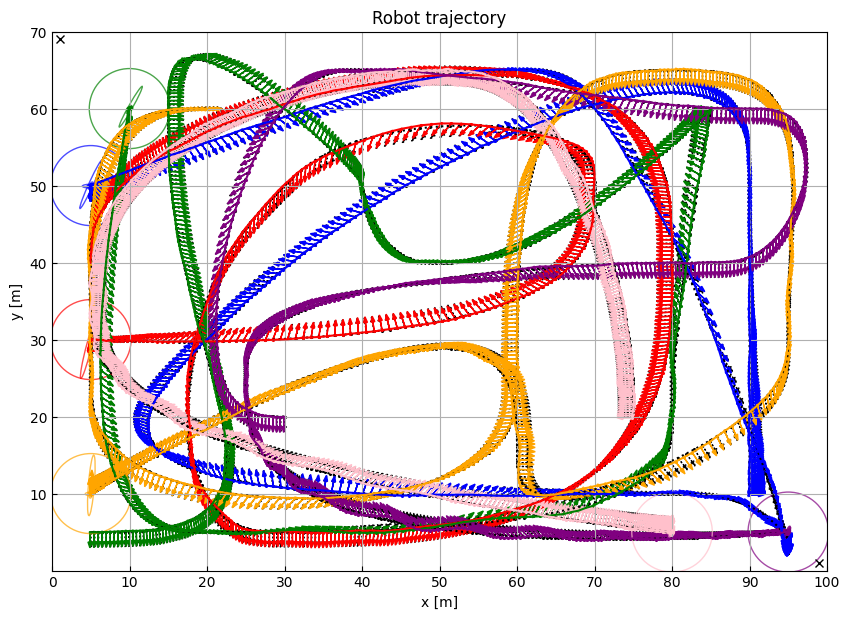

In [19]:
# Plot the choosen simulation:
s_idx = 6

# Plot ground truth
fig, ax = rp.setup_plot()
rp.plot_position(ax, pos1[:,::100], color='black', marker=None, linestyle=':', label='Robot 1 reference')
rp.plot_position(ax, pos2[:,::100], color='black', marker=None, linestyle=':', label='Robot 2 reference')
rp.plot_position(ax, pos3[:,::100], color='black', marker=None, linestyle=':', label='Robot 3 reference')
rp.plot_position(ax, pos4[:,::100], color='black', marker=None, linestyle=':', label='Robot 4 reference')
rp.plot_position(ax, pos5[:,::100], color='black', marker=None, linestyle=':', label='Robot 5 reference')
rp.plot_position(ax, pos6[:,::100], color='black', marker=None, linestyle=':', label='Robot 6 reference')

# Plot states of robots:
rp.plot_position2(ax, x_logL1[:,::100,s_idx], P_logL1[:,:,::100,s_idx], color='blue', marker=None, label='Robot 1 trajectory')
rp.plot_position2(ax, x_logL2[:,::100,s_idx], P_logL2[:,:,::100,s_idx], color='red', marker=None, label='Robot 2 trajectory')
rp.plot_position2(ax, x_logL3[:,::100,s_idx], P_logL3[:,:,::100,s_idx], color='green', marker=None, label='Robot 3 trajectory')
rp.plot_position2(ax, x_logL4[:,::100,s_idx], P_logL4[:,:,::100,s_idx], color='orange', marker=None, label='Robot 4 trajectory')
rp.plot_position2(ax, x_logL5[:,::100,s_idx], P_logL5[:,:,::100,s_idx], color='purple', marker=None, label='Robot 5 trajectory')
rp.plot_position2(ax, x_logL6[:,::100,s_idx], P_logL6[:,:,::100,s_idx], color='pink', marker=None, label='Robot 6 trajectory')

anchor1.draw_position(ax, color='black')
anchor2.draw_position(ax, color='black')

#ax.legend()

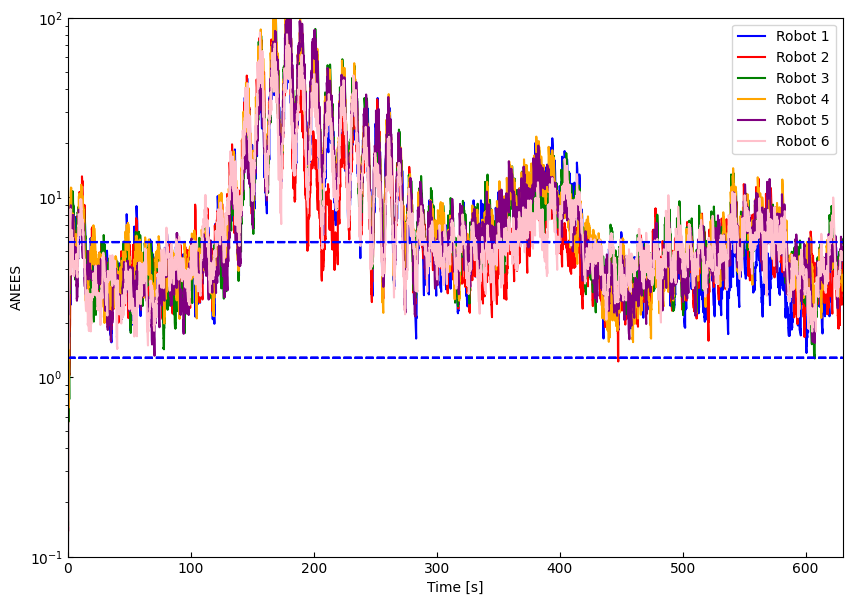

In [14]:
# Plot metrics:
# ANEES analysis
# If higher than confidence interval, then the estimate is overconfident
fig, ax_anees = plt.subplots(1, figsize=(10,7))
anees_sel = np.array([[True],[False],[False]])
pos_ind = [0, 2, 3]
#anees_sel = np.array([[False],[False]])
#pos_ind = [2, 3]
rp.plot_ANEES(ax_anees, 
             x_est=x_logL1[pos_ind,:],
             x_true=robotL1.path[:3,:], 
             P=P_logL1[np.ix_(pos_ind, pos_ind)], 
             rad_sel=anees_sel,
             dt=dt,
             prob=0.995,
             label='Robot 1')
rp.plot_ANEES(ax_anees, 
             x_est=x_logL2[pos_ind,:],
             x_true=robotL2.path[:3,:], 
             P=P_logL2[np.ix_(pos_ind, pos_ind)], 
             rad_sel=anees_sel,
             dt=dt,
             prob=0.995,
             color='red',
             label='Robot 2')
rp.plot_ANEES(ax_anees, 
             x_est=x_logL3[pos_ind,:],
             x_true=robotL3.path[:3,:], 
             P=P_logL3[np.ix_(pos_ind, pos_ind)], 
             rad_sel=anees_sel,
             dt=dt,
             prob=0.995,
             color='green',
             label='Robot 3')
rp.plot_ANEES(ax_anees, 
             x_est=x_logL4[pos_ind,:],
             x_true=robotL4.path[:3,:], 
             P=P_logL4[np.ix_(pos_ind, pos_ind)], 
             rad_sel=anees_sel,
             dt=dt,
             prob=0.995,
             color='orange',
             label='Robot 4')
rp.plot_ANEES(ax_anees, 
             x_est=x_logL5[pos_ind,:],
             x_true=robotL5.path[:3,:], 
             P=P_logL5[np.ix_(pos_ind, pos_ind)], 
             rad_sel=anees_sel,
             dt=dt,
             prob=0.995,
             color='purple',
             label='Robot 5')
rp.plot_ANEES(ax_anees, 
             x_est=x_logL6[pos_ind,:],
             x_true=robotL6.path[:3,:], 
             P=P_logL6[np.ix_(pos_ind, pos_ind)], 
             rad_sel=anees_sel,
             dt=dt,
             prob=0.995,
             color='pink',
             label='Robot 6')
ax_anees.set_ylim([0.1, 100])

ax_anees.legend()

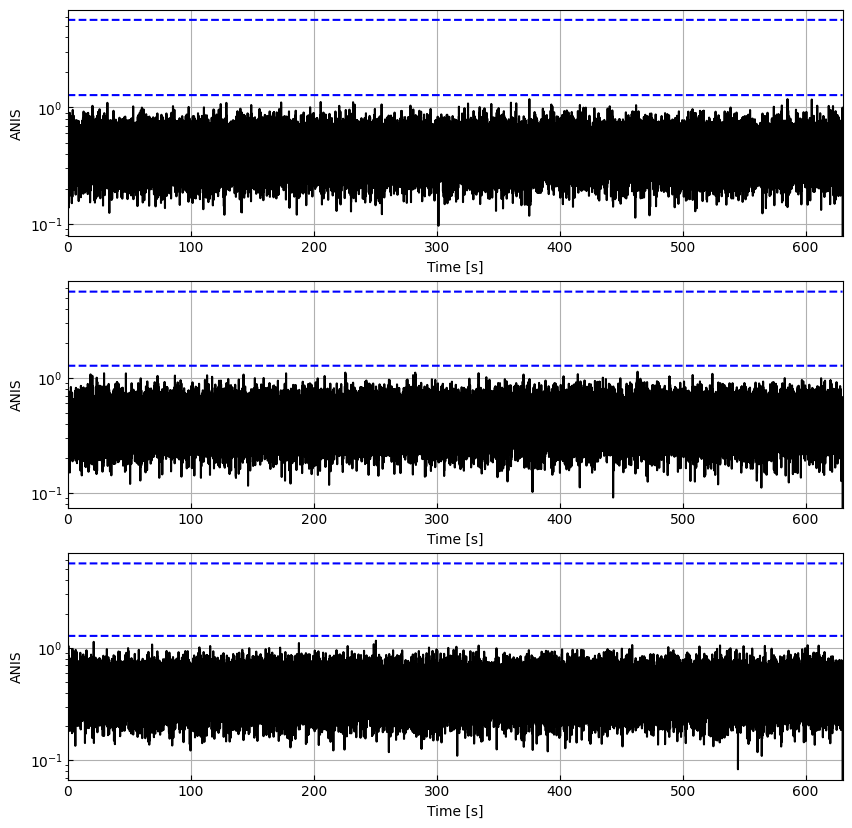

In [7]:
# ANIS analysis
fig, axnis = plt.subplots(3, figsize=(10,10))
# Three df
rp.plot_ANIS(ax=axnis[0], nis=nis_log1, df=3, dt=dt, prob=0.995, color='black')
rp.plot_ANIS(ax=axnis[1], nis=nis_log2, df=3, dt=dt, prob=0.995, color='black')
rp.plot_ANIS(ax=axnis[2], nis=nis_log3, df=3, dt=dt, prob=0.995, color='black')

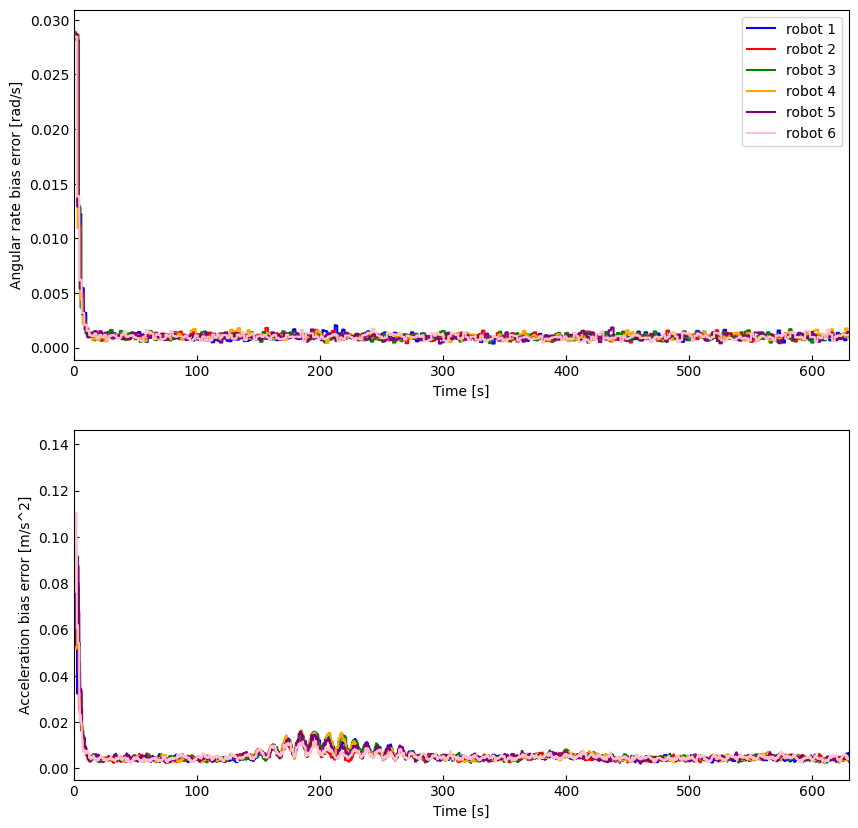

In [8]:
# Plot the absolute bias error:
fig, axbp = plt.subplots(2, figsize=(10,10))

rp.plot_abs_avg(axbp, abs_e_log1, dt=dt, pos=False, colors=['blue', 'blue'], labels=['robot 1', 'robot 1'])
rp.plot_abs_avg(axbp, abs_e_log2, dt=dt, pos=False, colors=['red','red'], labels=['robot 2', 'robot 2'])
rp.plot_abs_avg(axbp, abs_e_log3, dt=dt, pos=False, colors=['green', 'green'], labels=['robot 3', 'robot 3'])
rp.plot_abs_avg(axbp, abs_e_log4, dt=dt, pos=False, colors=['orange', 'orange'], labels=['robot 4', 'robot 4'])
rp.plot_abs_avg(axbp, abs_e_log5, dt=dt, pos=False, colors=['purple', 'purple'], labels=['robot 5', 'robot 5'])
rp.plot_abs_avg(axbp, abs_e_log6, dt=dt, pos=False, colors=['pink', 'pink'], labels=['robot 6', 'robot 6'])
axbp[0].legend()


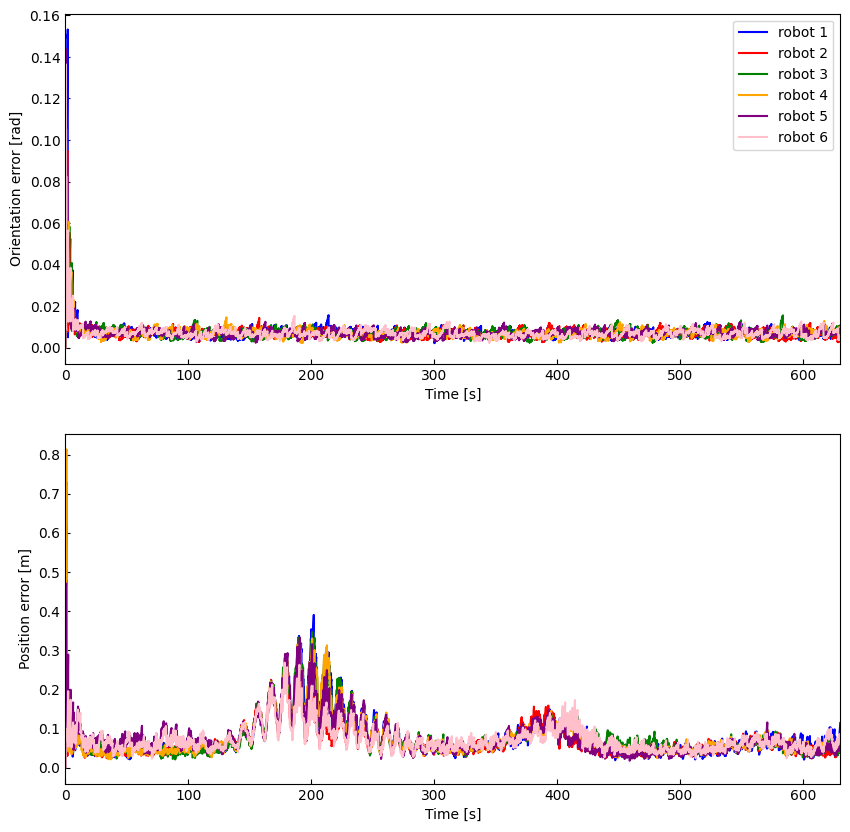

In [9]:
# Plot the absolute positioning error:
fig, axpos = plt.subplots(2, figsize=(10,10))

rp.plot_abs_avg(axpos, abs_e_log1, dt=dt, pos=True, colors=['blue', 'blue'], labels=['robot 1', 'robot 1'])
rp.plot_abs_avg(axpos, abs_e_log2, dt=dt, pos=True, colors=['red','red'], labels=['robot 2', 'robot 2'])
rp.plot_abs_avg(axpos, abs_e_log3, dt=dt, pos=True, colors=['green', 'green'], labels=['robot 3', 'robot 3'])
rp.plot_abs_avg(axpos, abs_e_log4, dt=dt, pos=True, colors=['orange', 'orange'], labels=['robot 4', 'robot 4'])
rp.plot_abs_avg(axpos, abs_e_log5, dt=dt, pos=True, colors=['purple','purple'], labels=['robot 5', 'robot 5'])
rp.plot_abs_avg(axpos, abs_e_log6, dt=dt, pos=True, colors=['pink', 'pink'], labels=['robot 6', 'robot 6'])
axpos[0].legend()

Interesting things to check:
- Anchor placements: If they are very close together, does the estimate then suffer?
- Daisy chain length: If there is a very long chain of drones with only these at the very end having connection to anchors, how does that affect the localization?
- Can a large group still keep consistency?
- What if communication is cut out at various points?
- How long can a group stay consistent, after communication is cut out? and can they recover?
- Outliers! (Important - how does the system handle these?)
    Only with anchors/IMU out: Filter has trouble maintaing consistency, but does not diverge 
- Fast drones with fast turning.
- Lot of orientation shifts (will ML fail?)

TODO:
- Try increasing covariance of measurments, ONLY for relative measurements, to prioritize anchor measurements better
- Dynamic thresholding: Based on the covariance of the bias estimates, decrease the thresholds
- Maximum threshold - just do handtuning

More notes:
- It seems that daisy chains are more susepticle to being thrown off by ML errors - its very dependent on both measurements being correct. If one happens, the system is then having a hard time to recover from it
